# tikreg tutorial: Banded ridge regression

`tikreg`: https://github.com/gallantlab/tikreg

This example follows Figure 5 from [Nunez-Elizalde, et al., 2019.](https://www.sciencedirect.com/science/article/pii/S1053811919302988?via%3Dihub)

For a technical description of banded ridge regression, checkout this [Notebook](https://nbviewer.jupyter.org/github/gallantlab/tikreg/blob/main/examples/tutorial_banded_ridge_polar.ipynb) or launch it on [Google Colab.](https://colab.research.google.com/github/gallantlab/tikreg/blob/main/examples/tutorial_banded_ridge_polar.ipynb)

# Banded ridge regression

When estimating a joint encoding model that consists of two feature spaces, banded ridge regression can be used to fit the model and assign each feature space a different regularization parameter. 

$$Y = X_1 \beta_1 + X_2 \beta_2 + \epsilon$$

$$
\begin{align*}
\beta_1 \sim \mathcal{N}\left(0, \lambda_1^{-2} I_p\right)\\
\beta_2 \sim \mathcal{N}\left(0, \lambda_2^{-2} I_q\right)\\
\end{align*}
$$

Estimating this model is computational expensive, requiring cross-validating two regularization parameters for every voxel ($\lambda_1$ and $\lambda_2$). 

In this tutorial, we'll perform banded ridge regression using data from a vision fMRI experiment (Nishimoto, et al., 2011). We'll be modeling voxel responses as a linear combination of motion energy and object category features. Instructions to download the fMRI data and the motion energy and object category features are provided below. Code to compute motion energy feature from arbitrary stimuli is provided in the Python package package ``pymoten`` ([github repo](https://github.com/gallantlab/pymoten/)).

This tutorial follows Figure 5 from [Nunez-Elizalde, et al., 2019.](https://www.sciencedirect.com/science/article/pii/S1053811919302988?via%3Dihub)

For a more technical description of banded ridge regression, checkout this [Notebook](https://nbviewer.jupyter.org/github/gallantlab/tikreg/blob/main/examples/tutorial_banded_ridge_polar.ipynb) or launch it on [Google Colab.](https://colab.research.google.com/github/gallantlab/tikreg/blob/main/examples/tutorial_banded_ridge_polar.ipynb)


## Requirements

In addition to `tikreg`, you'll need to install `h5py` to load the example data used in this tutorial and `matplotlib` to display the figures.

Uncomment the following line install the requirements:

In [1]:
#!pip install tikreg==0.0.1 h5py matplotlib

The data required to run this tutorial can be downloaded from this link or from the code below (~250MB): 
https://drive.google.com/open?id=1fcYosXaGsdS3u1xj8NMIC6ytEUbXMuGj.

Once downloaded, unzip the file contents and write them to the desired location (``root_directory``):

In [2]:
# Location of the unzipped data
root_directory = '.' # defaults to current working directory

In [3]:
## On linux (and maybe macs), you can use the following to download and unzip the data
## (from: https://gist.github.com/iamtekeste/3cdfd0366ebfd2c0d805#gistcomment-2316906)

if 0: # Change to 1 if running on e.g. Binder or Google Colab
    import os
    flname = 'tikreg_demodata.zip'
    unzipped_folder = 'tiny_vision'
    cmd = r'''wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILEID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILEID}" -O {FILENAME} && rm -rf /tmp/cookies.txt'''
    if not os.path.exists(flname) and not os.path.exists(unzipped_folder):
        os.system(cmd.format(FILEID='1fcYosXaGsdS3u1xj8NMIC6ytEUbXMuGj',FILENAME=flname))
    os.system('unzip -u tikreg_demodata.zip')
    assert os.path.exists(unzipped_folder)
    print('The exampled data for this notebook has been downloaded: %s'%unzipped_folder)

## Start

Now that we've downloaded the data, we are ready to proceed with the example.

In [4]:
%matplotlib inline

In [5]:
import os

import numpy as np
np.random.seed(1337)
np.set_printoptions(precision=4, suppress=True)

from scipy.stats import zscore
from matplotlib import pyplot as plt

import h5py
from tikreg import models, utils as tikutils
from tikreg import spatial_priors, temporal_priors

In [6]:
path = os.path.join(root_directory, 'tiny_vision')

moten_features_file = os.path.join(path, 'features', 'motion_energy.hdf')
object_categories_file = os.path.join(path, 'features', 'object_categories.hdf')
responses_file = os.path.join(path, 'responses', 'S1.hdf')
voxels_file = os.path.join(path, 'rois', 'S1.hdf')

In [7]:
def hdf_load(hdf_file, key=None):
    assert os.path.exists(hdf_file)
    
    with h5py.File(hdf_file, 'r') as hfl:
        hdf_content = hfl.keys()
        if key is None:
            e = ValueError('Please specify the HDF file content to load:', hdf_content)
            raise(e)
        assert key in hdf_content
        return np.asarray(hfl[key])

def plot_model_2dhist_comparison(corrs1, corrs2, name1, name2, cmap='inferno',
                                 ax=None, lims=(-0.5, 1.0), nbins=100, 
                                 title='model comparison\n(prediction accuracy [$r$])'):
    '''
    '''
    colormap = plt.cm.get_cmap(cmap)
    
    lo, hi = lims
    bins = np.linspace(lo, hi, nbins)
    h, xe, ye = np.histogram2d(corrs2,
                               corrs1,
                               bins=bins)

    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)

    im = ax.imshow(np.log(h), origin="lower", extent=(lo, hi, lo, hi), cmap=colormap, interpolation='nearest')
    ax.plot([lo, hi], [lo, hi], 'k-')
    ax.axis([lo, hi, lo, hi])


    ax.plot([0, 0], [lo, hi], color="0.1", linestyle=":")
    ax.plot([lo, hi], [0, 0], color="0.1", linestyle=":")

    ax.set_ylabel("%s model" % name2, fontsize=15)
    ax.set_xlabel("%s model" % name1, fontsize=15)

    cbar = plt.colorbar(im, orientation='vertical')
    cbar.set_label('voxel density [$log_{10}$]', fontsize=15)
    _ = ax.set_title(title, fontsize=20)
    return ax
    

In [8]:
Mtrain = hdf_load(moten_features_file, 'train')
Mtest = hdf_load(moten_features_file, 'test')
print(Mtrain.shape, Mtest.shape)

(3600, 6555) (270, 6555)


In [9]:
Otrain = hdf_load(object_categories_file, 'train')
Otest = hdf_load(object_categories_file, 'test')
print(Otrain.shape, Otest.shape)

(3600, 1705) (270, 1705)


In [10]:
Ytrain = hdf_load(responses_file, 'train')
Ytest = hdf_load(responses_file, 'test')
print(Ytrain.shape, Ytest.shape)

(3600, 2650) (270, 2650)


In [11]:
nfeaturesm = Mtrain.shape[1]
nfeatureso = Otrain.shape[1]
delays = np.arange(10)

In [10]:
moten_prior = spatial_priors.SphericalPrior(nfeaturesm)
obcat_prior = spatial_priors.SphericalPrior(nfeatureso)
temporal_prior = temporal_priors.SphericalPrior(delays=delays)

fit_spherical_pop = models.estimate_stem_wmvnp([Mtrain, Otrain], Ytrain, 
                                               [Mtest, Otest],Ytest,
                                               feature_priors=[moten_prior, obcat_prior],
                                               temporal_prior=temporal_prior,
                                               ridges=np.logspace(0,4,10),
                                               folds=(1,5),
                                               performance=True,
                                               population_optimal=True,
                                               verbosity=2)

1/1: temporal 1/1=1.000, features 1/1=(1.0000, 1.0000)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1998, (25,50,75)pctl=(0.0805,0.1721,0.3064),(0.0<r>0.5): (2557,077)
lambda 02:    2.783, mean=0.1998, (25,50,75)pctl=(0.0806,0.1721,0.3065),(0.0<r>0.5): (2557,078)
lambda 03:    7.743, mean=0.2002, (25,50,75)pctl=(0.0807,0.1726,0.3072),(0.0<r>0.5): (2557,078)
lambda 04:   21.544, mean=0.2028, (25,50,75)pctl=(0.0824,0.1753,0.3109),(0.0<r>0.5): (2559,085)
lambda 05:   59.948, mean=0.2153, (25,50,75)pctl=(0.0900,0.1908,0.3289),(0.0<r>0.5): (2561,114)
lambda 06:  166.810, mean=0.2420, (25,50,75)pctl=(0.1076,0.2235,0.3666),(0.0<r>0.5): (2576,194)
lambda 07:  464.159, mean=0.2544, (25,50,75)pctl=(0.1268,0.2433,0.3753),(0.0<r>0.5): (2587,191)
lambda 08: 1291.550, mean=0.2328, (25,50,75)pctl=(0.1216,0.2239,0.3372),(0.0<r>0.5): (2585,086)
lambda 09: 3593.814, mean=0.1976, (25,50,75)pctl=(0.0982,0.1851,0.2902),(0.0<r>0.5): (2549,014)
lambda 10: 10000.000, mean=0.1803, (25,50

In [11]:
moten_prior = spatial_priors.SphericalPrior(nfeaturesm)
obcat_prior = spatial_priors.SphericalPrior(nfeatureso)
temporal_prior = temporal_priors.SphericalPrior(delays=delays)

fit_spherical_vox = models.estimate_stem_wmvnp([Mtrain, Otrain], Ytrain,
                                               [Mtest, Otest],Ytest,
                                               feature_priors=[moten_prior, obcat_prior],
                                               temporal_prior=temporal_prior,
                                               ridges=np.logspace(0,4,10),
                                               folds=(1,5),
                                               performance=True,
                                               population_optimal=False,
                                               verbosity=2)

1/1: temporal 1/1=1.000, features 1/1=(1.0000, 1.0000)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2067, (25,50,75)pctl=(0.0835,0.1808,0.3121),(0.0<r>0.5): (2534,122)
lambda 02:    2.783, mean=0.2068, (25,50,75)pctl=(0.0835,0.1808,0.3122),(0.0<r>0.5): (2534,123)
lambda 03:    7.743, mean=0.2072, (25,50,75)pctl=(0.0836,0.1813,0.3127),(0.0<r>0.5): (2534,124)
lambda 04:   21.544, mean=0.2099, (25,50,75)pctl=(0.0854,0.1844,0.3163),(0.0<r>0.5): (2533,131)
lambda 05:   59.948, mean=0.2232, (25,50,75)pctl=(0.0943,0.1982,0.3378),(0.0<r>0.5): (2541,163)
lambda 06:  166.810, mean=0.2548, (25,50,75)pctl=(0.1154,0.2359,0.3834),(0.0<r>0.5): (2565,262)
lambda 07:  464.159, mean=0.2782, (25,50,75)pctl=(0.1413,0.2669,0.4109),(0.0<r>0.5): (2582,307)
lambda 08: 1291.550, mean=0.2599, (25,50,75)pctl=(0.1375,0.2508,0.3760),(0.0<r>0.5): (2580,177)
lambda 09: 3593.814, mean=0.2191, (25,50,75)pctl=(0.1134,0.2080,0.3185),(0.0<r>0.5): (2544,066)
lambda 10: 10000.000, mean=0.1980, (25,50

In [12]:
offset = 1.0
angle = np.linspace(0+offset, 90 - offset, 11)
angle = np.deg2rad(angle)
alpha1 = np.sin(angle)
alpha2 = np.cos(angle)
alphas = zip(alpha1, alpha2)
ratios = alpha1/alpha2
print(ratios)
print(alpha1)
print(alpha2)

[ 0.0175  0.1727  0.3365  0.5184  0.7319  1.      1.3663  1.9292  2.9714
  5.7894 57.29  ]
[0.0175 0.1702 0.319  0.4602 0.5906 0.7071 0.807  0.8878 0.9478 0.9854
 0.9998]
[0.9998 0.9854 0.9478 0.8878 0.807  0.7071 0.5906 0.4602 0.319  0.1702
 0.0175]


In [13]:
for ratio in ratios:
    dat = np.asarray([ratio, 1.0])
    dat /= np.linalg.norm(dat)
    print(round(ratio, 4), dat)

(0.0175, array([0.0175, 0.9998]))
(0.1727, array([0.1702, 0.9854]))
(0.3365, array([0.319 , 0.9478]))
(0.5184, array([0.4602, 0.8878]))
(0.7319, array([0.5906, 0.807 ]))
(1.0, array([0.7071, 0.7071]))
(1.3663, array([0.807 , 0.5906]))
(1.9292, array([0.8878, 0.4602]))
(2.9714, array([0.9478, 0.319 ]))
(5.7894, array([0.9854, 0.1702]))
(57.29, array([0.9998, 0.0175]))


In [14]:
ridges = ratios
moten_prior = spatial_priors.SphericalPrior(nfeaturesm, hyparams=[1.0])
obcat_prior = spatial_priors.SphericalPrior(nfeatureso, hyparams=ridges)
temporal_prior = temporal_priors.SphericalPrior(delays=delays)

In [15]:
fit_banded_polar = models.estimate_stem_wmvnp([Mtrain, Otrain], Ytrain, 
                                               [Mtest, Otest],Ytest,
                                               feature_priors=[moten_prior, obcat_prior],
                                               temporal_prior=temporal_prior,
                                               ridges=np.logspace(0,4,10),
                                               normalize_hyparams=True,
                                               folds=(1,5),
                                               performance=True,
                                               verbosity=2)

1/11: temporal 1/1=1.000, features 1/11=(0.9998, 0.0175)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1929, (25,50,75)pctl=(0.0878,0.1690,0.2880),(0.0<r>0.5): (2549,030)
lambda 02:    2.783, mean=0.1929, (25,50,75)pctl=(0.0878,0.1690,0.2880),(0.0<r>0.5): (2549,030)
lambda 03:    7.743, mean=0.1930, (25,50,75)pctl=(0.0878,0.1691,0.2881),(0.0<r>0.5): (2550,030)
lambda 04:   21.544, mean=0.1937, (25,50,75)pctl=(0.0884,0.1697,0.2888),(0.0<r>0.5): (2552,030)
lambda 05:   59.948, mean=0.1986, (25,50,75)pctl=(0.0924,0.1754,0.2946),(0.0<r>0.5): (2557,034)
lambda 06:  166.810, mean=0.2168, (25,50,75)pctl=(0.1037,0.1942,0.3224),(0.0<r>0.5): (2575,071)
lambda 07:  464.159, mean=0.2470, (25,50,75)pctl=(0.1212,0.2269,0.3652),(0.0<r>0.5): (2586,173)
lambda 08: 1291.550, mean=0.2730, (25,50,75)pctl=(0.1394,0.2627,0.4020),(0.0<r>0.5): (2590,279)
lambda 09: 3593.814, mean=0.2755, (25,50,75)pctl=(0.1452,0.2694,0.4052),(0.0<r>0.5): (2581,270)
lambda 10: 10000.000, mean=0.2577, (25,

train fold  4/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2254, (25,50,75)pctl=(0.0978,0.2017,0.3421),(0.0<r>0.5): (2570,146)
lambda 02:    2.783, mean=0.2254, (25,50,75)pctl=(0.0979,0.2017,0.3422),(0.0<r>0.5): (2570,146)
lambda 03:    7.743, mean=0.2258, (25,50,75)pctl=(0.0981,0.2021,0.3429),(0.0<r>0.5): (2570,147)
lambda 04:   21.544, mean=0.2286, (25,50,75)pctl=(0.0992,0.2046,0.3471),(0.0<r>0.5): (2572,164)
lambda 05:   59.948, mean=0.2425, (25,50,75)pctl=(0.1076,0.2172,0.3679),(0.0<r>0.5): (2575,213)
lambda 06:  166.810, mean=0.2775, (25,50,75)pctl=(0.1307,0.2587,0.4193),(0.0<r>0.5): (2592,364)
lambda 07:  464.159, mean=0.3043, (25,50,75)pctl=(0.1565,0.2961,0.4487),(0.0<r>0.5): (2604,446)
lambda 08: 1291.550, mean=0.2850, (25,50,75)pctl=(0.1536,0.2760,0.4160),(0.0<r>0.5): (2603,289)
lambda 09: 3593.814, mean=0.2352, (25,50,75)pctl=(0.1206,0.2267,0.3426),(0.0<r>0.5): (2578,083)
lambda 10: 10000.000, mean=0.2052, (25,50,75)pctl=(0.0993,0.1929,0.2995),(0.0<r>0.5): (2554,027)

lambda 10: 10000.000, mean=0.2275, (25,50,75)pctl=(0.1085,0.2093,0.3377),(0.0<r>0.5): (2527,154)
train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2190, (25,50,75)pctl=(0.0897,0.1938,0.3318),(0.0<r>0.5): (2561,162)
lambda 02:    2.783, mean=0.2191, (25,50,75)pctl=(0.0897,0.1938,0.3318),(0.0<r>0.5): (2561,162)
lambda 03:    7.743, mean=0.2194, (25,50,75)pctl=(0.0898,0.1940,0.3321),(0.0<r>0.5): (2560,162)
lambda 04:   21.544, mean=0.2213, (25,50,75)pctl=(0.0907,0.1959,0.3349),(0.0<r>0.5): (2558,169)
lambda 05:   59.948, mean=0.2311, (25,50,75)pctl=(0.0961,0.2066,0.3463),(0.0<r>0.5): (2563,203)
lambda 06:  166.810, mean=0.2554, (25,50,75)pctl=(0.1100,0.2369,0.3846),(0.0<r>0.5): (2574,274)
lambda 07:  464.159, mean=0.2715, (25,50,75)pctl=(0.1258,0.2587,0.4030),(0.0<r>0.5): (2584,321)
lambda 08: 1291.550, mean=0.2517, (25,50,75)pctl=(0.1221,0.2332,0.3701),(0.0<r>0.5): (2584,239)
lambda 09: 3593.814, mean=0.2156, (25,50,75)pctl=(0.1028,0.1898,0.3204),(0.0<r>0.5): (2555,117)

lambda 01:    1.000, mean=0.2146, (25,50,75)pctl=(0.0931,0.1880,0.3217),(0.0<r>0.5): (2575,134)
lambda 02:    2.783, mean=0.2146, (25,50,75)pctl=(0.0931,0.1880,0.3217),(0.0<r>0.5): (2575,134)
lambda 03:    7.743, mean=0.2148, (25,50,75)pctl=(0.0933,0.1882,0.3220),(0.0<r>0.5): (2575,134)
lambda 04:   21.544, mean=0.2164, (25,50,75)pctl=(0.0940,0.1896,0.3247),(0.0<r>0.5): (2576,142)
lambda 05:   59.948, mean=0.2252, (25,50,75)pctl=(0.0981,0.1986,0.3392),(0.0<r>0.5): (2582,170)
lambda 06:  166.810, mean=0.2501, (25,50,75)pctl=(0.1107,0.2271,0.3791),(0.0<r>0.5): (2583,264)
lambda 07:  464.159, mean=0.2770, (25,50,75)pctl=(0.1345,0.2606,0.4147),(0.0<r>0.5): (2593,346)
lambda 08: 1291.550, mean=0.2756, (25,50,75)pctl=(0.1457,0.2629,0.4037),(0.0<r>0.5): (2593,282)
lambda 09: 3593.814, mean=0.2479, (25,50,75)pctl=(0.1302,0.2368,0.3604),(0.0<r>0.5): (2592,147)
lambda 10: 10000.000, mean=0.2270, (25,50,75)pctl=(0.1161,0.2181,0.3310),(0.0<r>0.5): (2568,052)
pop.cv.best: 464.159, mean=0.2345, (25,

lambda 01:    1.000, mean=0.2111, (25,50,75)pctl=(0.0857,0.1826,0.3173),(0.0<r>0.5): (2569,128)
lambda 02:    2.783, mean=0.2111, (25,50,75)pctl=(0.0857,0.1827,0.3174),(0.0<r>0.5): (2569,128)
lambda 03:    7.743, mean=0.2112, (25,50,75)pctl=(0.0858,0.1829,0.3176),(0.0<r>0.5): (2569,130)
lambda 04:   21.544, mean=0.2124, (25,50,75)pctl=(0.0863,0.1842,0.3194),(0.0<r>0.5): (2569,134)
lambda 05:   59.948, mean=0.2193, (25,50,75)pctl=(0.0904,0.1912,0.3298),(0.0<r>0.5): (2574,153)
lambda 06:  166.810, mean=0.2424, (25,50,75)pctl=(0.1055,0.2191,0.3649),(0.0<r>0.5): (2592,213)
lambda 07:  464.159, mean=0.2715, (25,50,75)pctl=(0.1260,0.2565,0.4072),(0.0<r>0.5): (2612,309)
lambda 08: 1291.550, mean=0.2732, (25,50,75)pctl=(0.1357,0.2636,0.3982),(0.0<r>0.5): (2608,283)
lambda 09: 3593.814, mean=0.2461, (25,50,75)pctl=(0.1232,0.2330,0.3571),(0.0<r>0.5): (2589,185)
lambda 10: 10000.000, mean=0.2160, (25,50,75)pctl=(0.1007,0.2004,0.3162),(0.0<r>0.5): (2556,096)
train fold  4/5: ntrain=2880, ntest=720

train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2104, (25,50,75)pctl=(0.0847,0.1822,0.3210),(0.0<r>0.5): (2531,152)
lambda 02:    2.783, mean=0.2104, (25,50,75)pctl=(0.0847,0.1822,0.3210),(0.0<r>0.5): (2531,152)
lambda 03:    7.743, mean=0.2104, (25,50,75)pctl=(0.0847,0.1822,0.3211),(0.0<r>0.5): (2532,153)
lambda 04:   21.544, mean=0.2107, (25,50,75)pctl=(0.0849,0.1826,0.3215),(0.0<r>0.5): (2532,153)
lambda 05:   59.948, mean=0.2129, (25,50,75)pctl=(0.0860,0.1843,0.3240),(0.0<r>0.5): (2534,156)
lambda 06:  166.810, mean=0.2258, (25,50,75)pctl=(0.0930,0.1968,0.3431),(0.0<r>0.5): (2551,188)
lambda 07:  464.159, mean=0.2618, (25,50,75)pctl=(0.1143,0.2373,0.3941),(0.0<r>0.5): (2574,322)
lambda 08: 1291.550, mean=0.2921, (25,50,75)pctl=(0.1420,0.2790,0.4352),(0.0<r>0.5): (2586,433)
lambda 09: 3593.814, mean=0.2815, (25,50,75)pctl=(0.1393,0.2716,0.4138),(0.0<r>0.5): (2573,331)
lambda 10: 10000.000, mean=0.2478, (25,50,75)pctl=(0.1185,0.2327,0.3654),(0.0<r>0.5): (2549,210)

lambda 01:    1.000, mean=0.2002, (25,50,75)pctl=(0.0817,0.1693,0.3042),(0.0<r>0.5): (2533,105)
lambda 02:    2.783, mean=0.2002, (25,50,75)pctl=(0.0817,0.1693,0.3042),(0.0<r>0.5): (2533,105)
lambda 03:    7.743, mean=0.2002, (25,50,75)pctl=(0.0817,0.1693,0.3042),(0.0<r>0.5): (2533,105)
lambda 04:   21.544, mean=0.2003, (25,50,75)pctl=(0.0817,0.1694,0.3045),(0.0<r>0.5): (2533,105)
lambda 05:   59.948, mean=0.2011, (25,50,75)pctl=(0.0820,0.1703,0.3066),(0.0<r>0.5): (2534,109)
lambda 06:  166.810, mean=0.2061, (25,50,75)pctl=(0.0845,0.1743,0.3142),(0.0<r>0.5): (2538,119)
lambda 07:  464.159, mean=0.2277, (25,50,75)pctl=(0.0966,0.1975,0.3474),(0.0<r>0.5): (2557,172)
lambda 08: 1291.550, mean=0.2674, (25,50,75)pctl=(0.1227,0.2480,0.4027),(0.0<r>0.5): (2577,309)
lambda 09: 3593.814, mean=0.2842, (25,50,75)pctl=(0.1429,0.2753,0.4184),(0.0<r>0.5): (2595,338)
lambda 10: 10000.000, mean=0.2572, (25,50,75)pctl=(0.1310,0.2474,0.3764),(0.0<r>0.5): (2578,192)
train fold  5/5: ntrain=2880, ntest=720

lambda 01:  464.159, mean=0.0458, (25,50,75)pctl=(0.0073,0.0460,0.0886),(0.0<r>0.5): (013,000)
16 responses: ridge=  464.159, temporal=1.000, spatial=(1.000, 0.017) perf=0.0458
lambda 01: 1291.550, mean=0.3976, (25,50,75)pctl=(0.2487,0.2487,0.4721),(0.0<r>0.5): (003,001)
3 responses: ridge= 1291.550, temporal=1.000, spatial=(0.170, 0.985) perf=0.3976
lambda 01:  166.810, mean=-0.0001, (25,50,75)pctl=(-0.0412,0.0105,0.0335),(0.0<r>0.5): (013,000)
23 responses: ridge=  166.810, temporal=1.000, spatial=(1.000, 0.017) perf=-0.0001
lambda 01:    1.000, mean=0.0565, (25,50,75)pctl=(0.0078,0.0608,0.1096),(0.0<r>0.5): (003,000)
4 responses: ridge=    1.000, temporal=1.000, spatial=(1.000, 0.017) perf=0.0565
lambda 01:  166.810, mean=0.0196, (25,50,75)pctl=(-0.0492,-0.0492,0.0540),(0.0<r>0.5): (001,000)
3 responses: ridge=  166.810, temporal=1.000, spatial=(0.319, 0.948) perf=0.0196
lambda 01:  464.159, mean=0.5158, (25,50,75)pctl=(0.4185,0.5652,0.6568),(0.0<r>0.5): (864,538)
869 responses: rid

lambda 01: 3593.814, mean=0.4061, (25,50,75)pctl=(0.3154,0.4327,0.5346),(0.0<r>0.5): (442,156)
451 responses: ridge= 3593.814, temporal=1.000, spatial=(1.000, 0.017) perf=0.4061
lambda 01:  166.810, mean=-0.0619, (25,50,75)pctl=(-0.0619,-0.0619,-0.0619),(0.0<r>0.5): (000,000)
1 responses: ridge=  166.810, temporal=1.000, spatial=(0.017, 1.000) perf=-0.0619
lambda 01:    1.000, mean=0.0434, (25,50,75)pctl=(0.0135,0.0280,0.0881),(0.0<r>0.5): (005,000)
6 responses: ridge=    1.000, temporal=1.000, spatial=(0.017, 1.000) perf=0.0434
lambda 01:  166.810, mean=-0.0093, (25,50,75)pctl=(-0.0093,-0.0093,-0.0093),(0.0<r>0.5): (000,000)
1 responses: ridge=  166.810, temporal=1.000, spatial=(0.591, 0.807) perf=-0.0093
lambda 01: 10000.000, mean=-0.1693, (25,50,75)pctl=(-0.1693,-0.1693,-0.1693),(0.0<r>0.5): (000,000)
1 responses: ridge=10000.000, temporal=1.000, spatial=(0.707, 0.707) perf=-0.1693
lambda 01: 10000.000, mean=0.2389, (25,50,75)pctl=(0.2389,0.2389,0.2389),(0.0<r>0.5): (001,000)
1 resp

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


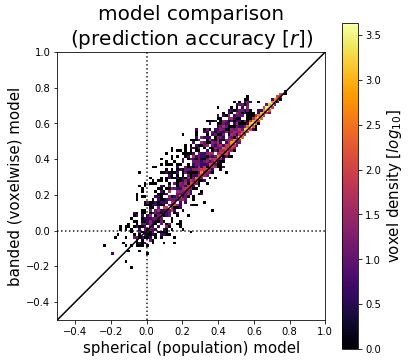

In [16]:
ax = plot_model_2dhist_comparison(np.nan_to_num(fit_spherical_pop['performance'].squeeze()),
                                  np.nan_to_num(fit_banded_polar['performance'].squeeze()),
                                  'spherical (population)', 'banded (voxelwise)')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


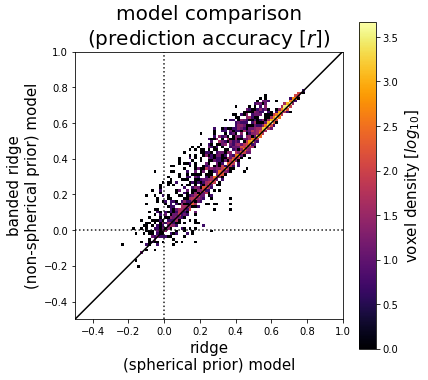

In [17]:
ax = plot_model_2dhist_comparison(np.nan_to_num(fit_spherical_vox['performance'].squeeze()),
                                  np.nan_to_num(fit_banded_polar['performance'].squeeze()),
                                  'ridge\n(spherical prior)', 'banded ridge\n(non-spherical prior)')

In [18]:
ridges = np.logspace(-2,4,10)
moten_prior = spatial_priors.SphericalPrior(nfeaturesm, hyparams=ridges)
obcat_prior = spatial_priors.SphericalPrior(nfeatureso, hyparams=ridges)
temporal_prior = temporal_priors.SphericalPrior(delays=delays)

fit_banded_grid = models.estimate_stem_wmvnp([Mtrain, Otrain], Ytrain, 
                                        [Mtest, Otest],Ytest,
                                        feature_priors=[moten_prior, obcat_prior],
                                        temporal_prior=temporal_prior,
                                        ridges=[1.0],
                                        folds=(1,5),
                                        performance=True,
                                        verbosity=2)


1/100: temporal 1/1=1.000, features 1/100=(0.0100, 0.0100)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2156, (25,50,75)pctl=(0.0859,0.1845,0.3275),(0.0<r>0.5): (2549,174)
train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1992, (25,50,75)pctl=(0.0763,0.1651,0.3018),(0.0<r>0.5): (2517,137)
train fold  3/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2111, (25,50,75)pctl=(0.0822,0.1824,0.3216),(0.0<r>0.5): (2539,143)
train fold  4/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2080, (25,50,75)pctl=(0.0839,0.1792,0.3178),(0.0<r>0.5): (2548,113)
train fold  5/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2077, (25,50,75)pctl=(0.0835,0.1759,0.3133),(0.0<r>0.5): (2541,136)
pop.cv.best:  1.000, mean=0.2083, (25,50,75)pctl=(0.0802,0.1746,0.3136),(0.0<r>0.5): (2615,132)
2/100: temporal 1/1=1.000, features 2/100=(0.0100, 0.0464)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2102, (25,50,75)pctl=(0.0826,0.1776,0.

train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2345, (25,50,75)pctl=(0.0980,0.2054,0.3562),(0.0<r>0.5): (2583,208)
train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2160, (25,50,75)pctl=(0.0868,0.1883,0.3280),(0.0<r>0.5): (2549,149)
train fold  3/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2303, (25,50,75)pctl=(0.0945,0.2036,0.3507),(0.0<r>0.5): (2561,193)
train fold  4/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2247, (25,50,75)pctl=(0.0979,0.1993,0.3405),(0.0<r>0.5): (2574,146)
train fold  5/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2272, (25,50,75)pctl=(0.0960,0.1965,0.3421),(0.0<r>0.5): (2562,169)
pop.cv.best:  1.000, mean=0.2265, (25,50,75)pctl=(0.0960,0.1963,0.3441),(0.0<r>0.5): (2624,166)
12/100: temporal 1/1=1.000, features 12/100=(0.0464, 0.0464)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2156, (25,50,75)pctl=(0.0859,0.1845,0.3275),(0.0<r>0.5): (2549,174)
train fold  2/5: ntrain=288

train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2242, (25,50,75)pctl=(0.0954,0.1983,0.3369),(0.0<r>0.5): (2579,151)
train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2031, (25,50,75)pctl=(0.0888,0.1768,0.3103),(0.0<r>0.5): (2547,083)
train fold  3/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2217, (25,50,75)pctl=(0.0956,0.1968,0.3380),(0.0<r>0.5): (2567,132)
train fold  4/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2226, (25,50,75)pctl=(0.1026,0.1985,0.3288),(0.0<r>0.5): (2598,089)
train fold  5/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2193, (25,50,75)pctl=(0.0961,0.1922,0.3260),(0.0<r>0.5): (2572,127)
pop.cv.best:  1.000, mean=0.2182, (25,50,75)pctl=(0.0958,0.1858,0.3261),(0.0<r>0.5): (2618,115)
22/100: temporal 1/1=1.000, features 22/100=(0.2154, 0.0464)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2345, (25,50,75)pctl=(0.0980,0.2054,0.3562),(0.0<r>0.5): (2583,208)
train fold  2/5: ntrain=288

train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1659, (25,50,75)pctl=(0.0707,0.1410,0.2490),(0.0<r>0.5): (2521,009)
train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1505, (25,50,75)pctl=(0.0620,0.1299,0.2264),(0.0<r>0.5): (2493,003)
train fold  3/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1735, (25,50,75)pctl=(0.0699,0.1476,0.2647),(0.0<r>0.5): (2523,020)
train fold  4/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1720, (25,50,75)pctl=(0.0819,0.1534,0.2510),(0.0<r>0.5): (2568,009)
train fold  5/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1592, (25,50,75)pctl=(0.0672,0.1336,0.2340),(0.0<r>0.5): (2537,011)
pop.cv.best:  1.000, mean=0.1642, (25,50,75)pctl=(0.0721,0.1353,0.2414),(0.0<r>0.5): (2607,004)
32/100: temporal 1/1=1.000, features 32/100=(1.0000, 0.0464)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.2242, (25,50,75)pctl=(0.0954,0.1983,0.3369),(0.0<r>0.5): (2579,151)
train fold  2/5: ntrain=288

train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1168, (25,50,75)pctl=(0.0463,0.0989,0.1754),(0.0<r>0.5): (2461,003)
train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1084, (25,50,75)pctl=(0.0436,0.0946,0.1621),(0.0<r>0.5): (2454,000)
train fold  3/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1264, (25,50,75)pctl=(0.0507,0.1087,0.1920),(0.0<r>0.5): (2457,000)
train fold  4/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1264, (25,50,75)pctl=(0.0610,0.1111,0.1757),(0.0<r>0.5): (2519,002)
train fold  5/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1121, (25,50,75)pctl=(0.0440,0.0926,0.1662),(0.0<r>0.5): (2444,001)
pop.cv.best:  1.000, mean=0.1181, (25,50,75)pctl=(0.0530,0.0980,0.1689),(0.0<r>0.5): (2589,000)
42/100: temporal 1/1=1.000, features 42/100=(4.6416, 0.0464)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1659, (25,50,75)pctl=(0.0707,0.1410,0.2490),(0.0<r>0.5): (2521,009)
train fold  2/5: ntrain=288

train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1013, (25,50,75)pctl=(0.0398,0.0849,0.1476),(0.0<r>0.5): (2423,003)
train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.0917, (25,50,75)pctl=(0.0345,0.0801,0.1350),(0.0<r>0.5): (2413,000)
train fold  3/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1089, (25,50,75)pctl=(0.0436,0.0963,0.1647),(0.0<r>0.5): (2427,000)
train fold  4/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1109, (25,50,75)pctl=(0.0546,0.0971,0.1503),(0.0<r>0.5): (2507,001)
train fold  5/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.0979, (25,50,75)pctl=(0.0364,0.0820,0.1430),(0.0<r>0.5): (2395,001)
pop.cv.best:  1.000, mean=0.1021, (25,50,75)pctl=(0.0473,0.0861,0.1420),(0.0<r>0.5): (2582,000)
52/100: temporal 1/1=1.000, features 52/100=(21.5443, 0.0464)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1169, (25,50,75)pctl=(0.0464,0.0990,0.1755),(0.0<r>0.5): (2461,003)
train fold  2/5: ntrain=28

train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1001, (25,50,75)pctl=(0.0396,0.0842,0.1454),(0.0<r>0.5): (2422,003)
train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.0902, (25,50,75)pctl=(0.0334,0.0792,0.1327),(0.0<r>0.5): (2410,000)
train fold  3/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1074, (25,50,75)pctl=(0.0432,0.0945,0.1615),(0.0<r>0.5): (2422,000)
train fold  4/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1097, (25,50,75)pctl=(0.0537,0.0955,0.1484),(0.0<r>0.5): (2507,001)
train fold  5/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.0967, (25,50,75)pctl=(0.0357,0.0807,0.1414),(0.0<r>0.5): (2391,001)
pop.cv.best:  1.000, mean=0.1008, (25,50,75)pctl=(0.0465,0.0846,0.1393),(0.0<r>0.5): (2581,000)
62/100: temporal 1/1=1.000, features 62/100=(100.0000, 0.0464)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1014, (25,50,75)pctl=(0.0399,0.0850,0.1477),(0.0<r>0.5): (2424,003)
train fold  2/5: ntrain=2

train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1000, (25,50,75)pctl=(0.0395,0.0841,0.1453),(0.0<r>0.5): (2422,003)
train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.0902, (25,50,75)pctl=(0.0333,0.0792,0.1327),(0.0<r>0.5): (2410,000)
train fold  3/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1073, (25,50,75)pctl=(0.0431,0.0945,0.1613),(0.0<r>0.5): (2422,000)
train fold  4/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1096, (25,50,75)pctl=(0.0537,0.0954,0.1484),(0.0<r>0.5): (2507,001)
train fold  5/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.0967, (25,50,75)pctl=(0.0356,0.0806,0.1413),(0.0<r>0.5): (2391,001)
pop.cv.best:  1.000, mean=0.1008, (25,50,75)pctl=(0.0465,0.0845,0.1393),(0.0<r>0.5): (2581,000)
72/100: temporal 1/1=1.000, features 72/100=(464.1589, 0.0464)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1001, (25,50,75)pctl=(0.0396,0.0842,0.1454),(0.0<r>0.5): (2422,003)
train fold  2/5: ntrain=2

train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1000, (25,50,75)pctl=(0.0395,0.0841,0.1453),(0.0<r>0.5): (2422,003)
train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.0902, (25,50,75)pctl=(0.0333,0.0792,0.1327),(0.0<r>0.5): (2410,000)
train fold  3/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1073, (25,50,75)pctl=(0.0431,0.0945,0.1613),(0.0<r>0.5): (2422,000)
train fold  4/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1096, (25,50,75)pctl=(0.0537,0.0954,0.1484),(0.0<r>0.5): (2507,001)
train fold  5/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.0967, (25,50,75)pctl=(0.0356,0.0806,0.1413),(0.0<r>0.5): (2391,001)
pop.cv.best:  1.000, mean=0.1007, (25,50,75)pctl=(0.0465,0.0845,0.1393),(0.0<r>0.5): (2581,000)
82/100: temporal 1/1=1.000, features 82/100=(2154.4347, 0.0464)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1001, (25,50,75)pctl=(0.0396,0.0842,0.1453),(0.0<r>0.5): (2422,003)
train fold  2/5: ntrain=

train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1000, (25,50,75)pctl=(0.0395,0.0841,0.1453),(0.0<r>0.5): (2422,003)
train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.0902, (25,50,75)pctl=(0.0333,0.0792,0.1327),(0.0<r>0.5): (2410,000)
train fold  3/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1073, (25,50,75)pctl=(0.0431,0.0945,0.1613),(0.0<r>0.5): (2422,000)
train fold  4/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1096, (25,50,75)pctl=(0.0537,0.0954,0.1484),(0.0<r>0.5): (2507,001)
train fold  5/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.0967, (25,50,75)pctl=(0.0356,0.0806,0.1413),(0.0<r>0.5): (2391,001)
pop.cv.best:  1.000, mean=0.1007, (25,50,75)pctl=(0.0465,0.0845,0.1393),(0.0<r>0.5): (2581,000)
92/100: temporal 1/1=1.000, features 92/100=(10000.0000, 0.0464)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1001, (25,50,75)pctl=(0.0396,0.0842,0.1453),(0.0<r>0.5): (2422,003)
train fold  2/5: ntrain

lambda 01:    1.000, mean=0.5405, (25,50,75)pctl=(0.4601,0.5866,0.6666),(0.0<r>0.5): (1144,774)
1147 responses: ridge=    1.000, temporal=1.000, spatial=(464.159, 100.000) perf=0.5405
lambda 01:    1.000, mean=-0.0022, (25,50,75)pctl=(-0.0374,-0.0069,0.0415),(0.0<r>0.5): (003,000)
8 responses: ridge=    1.000, temporal=1.000, spatial=(21.544, 4.642) perf=-0.0022
lambda 01:    1.000, mean=0.3032, (25,50,75)pctl=(0.2110,0.3191,0.3939),(0.0<r>0.5): (058,004)
58 responses: ridge=    1.000, temporal=1.000, spatial=(2154.435, 464.159) perf=0.3032
lambda 01:    1.000, mean=-0.0062, (25,50,75)pctl=(-0.0589,0.0456,0.0681),(0.0<r>0.5): (004,000)
7 responses: ridge=    1.000, temporal=1.000, spatial=(464.159, 4.642) perf=-0.0062
lambda 01:    1.000, mean=-0.0188, (25,50,75)pctl=(-0.0280,-0.0188,-0.0097),(0.0<r>0.5): (000,000)
2 responses: ridge=    1.000, temporal=1.000, spatial=(10000.000, 0.010) perf=-0.0188
lambda 01:    1.000, mean=0.0361, (25,50,75)pctl=(0.0200,0.0653,0.0814),(0.0<r>0.5): (0

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Text(0.5,1,u'hyper-parameter search\n(polar vs grid)')

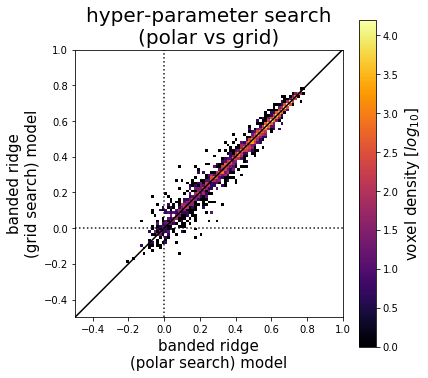

In [19]:
ax = plot_model_2dhist_comparison(np.nan_to_num(fit_banded_polar['performance'].squeeze()),
                                  np.nan_to_num(fit_banded_grid['performance'].squeeze()),
                                  'banded ridge\n(polar search)', 
                                  'banded ridge\n(grid search)')
ax.set_title('hyper-parameter search\n(polar vs grid)', fontsize=20)

In [20]:
offset = 1
angle = np.linspace(0+offset, 90 - offset, 11)
angle = np.deg2rad(angle)
alpha1 = np.sin(angle)
alpha2 = np.cos(angle)
alphas = zip(alpha1, alpha2)
ratios = alpha1/alpha2
print(ratios)
print(alpha1)
print(alpha2)

[ 0.0175  0.1727  0.3365  0.5184  0.7319  1.      1.3663  1.9292  2.9714
  5.7894 57.29  ]
[0.0175 0.1702 0.319  0.4602 0.5906 0.7071 0.807  0.8878 0.9478 0.9854
 0.9998]
[0.9998 0.9854 0.9478 0.8878 0.807  0.7071 0.5906 0.4602 0.319  0.1702
 0.0175]


In [21]:
ridges = ratios
moten_prior = spatial_priors.SphericalPrior(nfeaturesm, hyparams=[1.0])
obcat_prior = spatial_priors.SphericalPrior(nfeatureso, hyparams=ridges)
temporal_prior = temporal_priors.HRFPrior(delays=delays)

In [22]:
fit_bandedhrf_polar = models.estimate_stem_wmvnp([Mtrain, Otrain], Ytrain, 
                                               [Mtest, Otest],Ytest,
                                               feature_priors=[moten_prior, obcat_prior],
                                               temporal_prior=temporal_prior,
                                               ridges=np.logspace(0,4,10),
                                               normalize_hyparams=True,
                                               folds=(1,5),
                                               performance=True,
                                               verbosity=2)

1/11: temporal 1/1=1.000, features 1/11=(0.9998, 0.0175)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.0709, (25,50,75)pctl=(0.0155,0.0597,0.1150),(0.0<r>0.5): (2178,000)
lambda 02:    2.783, mean=0.0748, (25,50,75)pctl=(0.0173,0.0625,0.1201),(0.0<r>0.5): (2197,000)
lambda 03:    7.743, mean=0.0936, (25,50,75)pctl=(0.0279,0.0775,0.1463),(0.0<r>0.5): (2301,000)
lambda 04:   21.544, mean=0.1420, (25,50,75)pctl=(0.0523,0.1198,0.2192),(0.0<r>0.5): (2443,003)
lambda 05:   59.948, mean=0.2056, (25,50,75)pctl=(0.0891,0.1790,0.3126),(0.0<r>0.5): (2550,057)
lambda 06:  166.810, mean=0.2520, (25,50,75)pctl=(0.1214,0.2331,0.3767),(0.0<r>0.5): (2603,199)
lambda 07:  464.159, mean=0.2778, (25,50,75)pctl=(0.1401,0.2598,0.4142),(0.0<r>0.5): (2611,317)
lambda 08: 1291.550, mean=0.2853, (25,50,75)pctl=(0.1453,0.2710,0.4202),(0.0<r>0.5): (2608,330)
lambda 09: 3593.814, mean=0.2686, (25,50,75)pctl=(0.1406,0.2591,0.3914),(0.0<r>0.5): (2601,215)
lambda 10: 10000.000, mean=0.2456, (25,

lambda 01:    1.000, mean=0.1264, (25,50,75)pctl=(0.0518,0.1063,0.1918),(0.0<r>0.5): (2457,001)
lambda 02:    2.783, mean=0.1366, (25,50,75)pctl=(0.0566,0.1160,0.2066),(0.0<r>0.5): (2475,004)
lambda 03:    7.743, mean=0.1735, (25,50,75)pctl=(0.0744,0.1492,0.2569),(0.0<r>0.5): (2534,026)
lambda 04:   21.544, mean=0.2341, (25,50,75)pctl=(0.1130,0.2133,0.3435),(0.0<r>0.5): (2582,149)
lambda 05:   59.948, mean=0.2777, (25,50,75)pctl=(0.1468,0.2591,0.4036),(0.0<r>0.5): (2612,313)
lambda 06:  166.810, mean=0.3003, (25,50,75)pctl=(0.1647,0.2844,0.4363),(0.0<r>0.5): (2623,407)
lambda 07:  464.159, mean=0.3039, (25,50,75)pctl=(0.1719,0.2941,0.4366),(0.0<r>0.5): (2619,416)
lambda 08: 1291.550, mean=0.2733, (25,50,75)pctl=(0.1529,0.2647,0.3945),(0.0<r>0.5): (2599,221)
lambda 09: 3593.814, mean=0.2200, (25,50,75)pctl=(0.1172,0.2099,0.3202),(0.0<r>0.5): (2561,047)
lambda 10: 10000.000, mean=0.1893, (25,50,75)pctl=(0.0917,0.1761,0.2763),(0.0<r>0.5): (2519,014)
train fold  5/5: ntrain=2880, ntest=720

lambda 01:    1.000, mean=0.1105, (25,50,75)pctl=(0.0360,0.0954,0.1692),(0.0<r>0.5): (2365,000)
lambda 02:    2.783, mean=0.1203, (25,50,75)pctl=(0.0412,0.1037,0.1824),(0.0<r>0.5): (2377,002)
lambda 03:    7.743, mean=0.1572, (25,50,75)pctl=(0.0609,0.1369,0.2375),(0.0<r>0.5): (2450,022)
lambda 04:   21.544, mean=0.2213, (25,50,75)pctl=(0.1016,0.1993,0.3348),(0.0<r>0.5): (2544,128)
lambda 05:   59.948, mean=0.2716, (25,50,75)pctl=(0.1344,0.2530,0.3987),(0.0<r>0.5): (2594,291)
lambda 06:  166.810, mean=0.3033, (25,50,75)pctl=(0.1541,0.2905,0.4407),(0.0<r>0.5): (2612,441)
lambda 07:  464.159, mean=0.3139, (25,50,75)pctl=(0.1641,0.3067,0.4516),(0.0<r>0.5): (2616,470)
lambda 08: 1291.550, mean=0.2949, (25,50,75)pctl=(0.1560,0.2829,0.4228),(0.0<r>0.5): (2602,371)
lambda 09: 3593.814, mean=0.2529, (25,50,75)pctl=(0.1284,0.2361,0.3618),(0.0<r>0.5): (2588,216)
lambda 10: 10000.000, mean=0.2208, (25,50,75)pctl=(0.1021,0.1954,0.3241),(0.0<r>0.5): (2547,152)
train fold  3/5: ntrain=2880, ntest=720

lambda 04:   21.544, mean=0.2272, (25,50,75)pctl=(0.0966,0.1973,0.3467),(0.0<r>0.5): (2552,185)
lambda 05:   59.948, mean=0.2733, (25,50,75)pctl=(0.1308,0.2517,0.4046),(0.0<r>0.5): (2602,328)
lambda 06:  166.810, mean=0.2990, (25,50,75)pctl=(0.1479,0.2878,0.4390),(0.0<r>0.5): (2613,425)
lambda 07:  464.159, mean=0.3091, (25,50,75)pctl=(0.1659,0.3035,0.4459),(0.0<r>0.5): (2613,444)
lambda 08: 1291.550, mean=0.2979, (25,50,75)pctl=(0.1654,0.2963,0.4260),(0.0<r>0.5): (2595,341)
lambda 09: 3593.814, mean=0.2656, (25,50,75)pctl=(0.1476,0.2634,0.3821),(0.0<r>0.5): (2583,169)
lambda 10: 10000.000, mean=0.2359, (25,50,75)pctl=(0.1270,0.2300,0.3425),(0.0<r>0.5): (2558,096)
pop.cv.best: 464.159, mean=0.2213, (25,50,75)pctl=(0.1643,0.2936,0.4411),(0.0<r>0.5): (2649,408)
6/11: temporal 1/1=1.000, features 6/11=(0.7071, 0.7071)
train fold  1/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1086, (25,50,75)pctl=(0.0346,0.0871,0.1656),(0.0<r>0.5): (2356,001)
lambda 02:    2.783, mean=0.1151, (25

lambda 04:   21.544, mean=0.1890, (25,50,75)pctl=(0.0712,0.1566,0.2913),(0.0<r>0.5): (2507,102)
lambda 05:   59.948, mean=0.2417, (25,50,75)pctl=(0.1061,0.2118,0.3594),(0.0<r>0.5): (2572,240)
lambda 06:  166.810, mean=0.2722, (25,50,75)pctl=(0.1252,0.2466,0.4094),(0.0<r>0.5): (2597,349)
lambda 07:  464.159, mean=0.2892, (25,50,75)pctl=(0.1401,0.2759,0.4259),(0.0<r>0.5): (2600,381)
lambda 08: 1291.550, mean=0.2825, (25,50,75)pctl=(0.1483,0.2748,0.4060),(0.0<r>0.5): (2600,297)
lambda 09: 3593.814, mean=0.2445, (25,50,75)pctl=(0.1283,0.2306,0.3489),(0.0<r>0.5): (2586,152)
lambda 10: 10000.000, mean=0.2022, (25,50,75)pctl=(0.0977,0.1834,0.2920),(0.0<r>0.5): (2541,067)
train fold  4/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1160, (25,50,75)pctl=(0.0438,0.0970,0.1731),(0.0<r>0.5): (2422,000)
lambda 02:    2.783, mean=0.1207, (25,50,75)pctl=(0.0467,0.1010,0.1807),(0.0<r>0.5): (2437,000)
lambda 03:    7.743, mean=0.1432, (25,50,75)pctl=(0.0575,0.1214,0.2155),(0.0<r>0.5): (2487,007)

lambda 04:   21.544, mean=0.1513, (25,50,75)pctl=(0.0532,0.1219,0.2266),(0.0<r>0.5): (2466,032)
lambda 05:   59.948, mean=0.2108, (25,50,75)pctl=(0.0859,0.1773,0.3193),(0.0<r>0.5): (2554,156)
lambda 06:  166.810, mean=0.2563, (25,50,75)pctl=(0.1130,0.2289,0.3875),(0.0<r>0.5): (2594,301)
lambda 07:  464.159, mean=0.2855, (25,50,75)pctl=(0.1321,0.2677,0.4279),(0.0<r>0.5): (2607,405)
lambda 08: 1291.550, mean=0.3011, (25,50,75)pctl=(0.1517,0.2942,0.4425),(0.0<r>0.5): (2617,427)
lambda 09: 3593.814, mean=0.2894, (25,50,75)pctl=(0.1527,0.2810,0.4217),(0.0<r>0.5): (2614,326)
lambda 10: 10000.000, mean=0.2536, (25,50,75)pctl=(0.1305,0.2449,0.3667),(0.0<r>0.5): (2591,186)
train fold  2/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1047, (25,50,75)pctl=(0.0329,0.0886,0.1598),(0.0<r>0.5): (2340,000)
lambda 02:    2.783, mean=0.1062, (25,50,75)pctl=(0.0336,0.0898,0.1616),(0.0<r>0.5): (2344,000)
lambda 03:    7.743, mean=0.1159, (25,50,75)pctl=(0.0379,0.0976,0.1775),(0.0<r>0.5): (2367,002)

lambda 07:  464.159, mean=0.2658, (25,50,75)pctl=(0.1368,0.2412,0.3927),(0.0<r>0.5): (2603,275)
lambda 08: 1291.550, mean=0.2864, (25,50,75)pctl=(0.1520,0.2686,0.4199),(0.0<r>0.5): (2619,350)
lambda 09: 3593.814, mean=0.2836, (25,50,75)pctl=(0.1565,0.2700,0.4094),(0.0<r>0.5): (2605,302)
lambda 10: 10000.000, mean=0.2454, (25,50,75)pctl=(0.1325,0.2327,0.3556),(0.0<r>0.5): (2580,137)
train fold  5/5: ntrain=2880, ntest=720
lambda 01:    1.000, mean=0.1224, (25,50,75)pctl=(0.0377,0.0989,0.1880),(0.0<r>0.5): (2380,007)
lambda 02:    2.783, mean=0.1229, (25,50,75)pctl=(0.0380,0.0992,0.1889),(0.0<r>0.5): (2381,007)
lambda 03:    7.743, mean=0.1259, (25,50,75)pctl=(0.0398,0.1014,0.1943),(0.0<r>0.5): (2386,007)
lambda 04:   21.544, mean=0.1427, (25,50,75)pctl=(0.0473,0.1161,0.2205),(0.0<r>0.5): (2421,023)
lambda 05:   59.948, mean=0.1892, (25,50,75)pctl=(0.0733,0.1567,0.2911),(0.0<r>0.5): (2496,093)
lambda 06:  166.810, mean=0.2442, (25,50,75)pctl=(0.1078,0.2180,0.3689),(0.0<r>0.5): (2577,235)

lambda 01:  166.810, mean=0.0503, (25,50,75)pctl=(-0.0052,0.0362,0.1019),(0.0<r>0.5): (028,000)
41 responses: ridge=  166.810, temporal=1.000, spatial=(1.000, 0.017) perf=0.0503
lambda 01:    1.000, mean=0.0669, (25,50,75)pctl=(0.0480,0.0669,0.0857),(0.0<r>0.5): (002,000)
2 responses: ridge=    1.000, temporal=1.000, spatial=(1.000, 0.017) perf=0.0669
lambda 01:   59.948, mean=-0.0106, (25,50,75)pctl=(-0.0106,-0.0106,-0.0106),(0.0<r>0.5): (000,000)
1 responses: ridge=   59.948, temporal=1.000, spatial=(0.888, 0.460) perf=-0.0106
lambda 01:  464.159, mean=0.4939, (25,50,75)pctl=(0.3892,0.5323,0.6365),(0.0<r>0.5): (625,351)
629 responses: ridge=  464.159, temporal=1.000, spatial=(0.985, 0.170) perf=0.4939
lambda 01: 3593.814, mean=0.2111, (25,50,75)pctl=(0.1799,0.2271,0.2504),(0.0<r>0.5): (003,000)
3 responses: ridge= 3593.814, temporal=1.000, spatial=(0.707, 0.707) perf=0.2111
lambda 01: 10000.000, mean=-0.1516, (25,50,75)pctl=(-0.1516,-0.1516,-0.1516),(0.0<r>0.5): (000,000)
1 responses

lambda 01:    7.743, mean=0.0701, (25,50,75)pctl=(0.0701,0.0701,0.0701),(0.0<r>0.5): (001,000)
1 responses: ridge=    7.743, temporal=1.000, spatial=(0.985, 0.170) perf=0.0701
lambda 01: 1291.550, mean=0.4132, (25,50,75)pctl=(0.2693,0.4610,0.5374),(0.0<r>0.5): (059,027)
60 responses: ridge= 1291.550, temporal=1.000, spatial=(0.319, 0.948) perf=0.4132
lambda 01: 3593.814, mean=0.3764, (25,50,75)pctl=(0.3081,0.3993,0.4753),(0.0<r>0.5): (183,036)
185 responses: ridge= 3593.814, temporal=1.000, spatial=(1.000, 0.017) perf=0.3764
lambda 01:  166.810, mean=0.0968, (25,50,75)pctl=(0.0717,0.1170,0.1321),(0.0<r>0.5): (003,000)
3 responses: ridge=  166.810, temporal=1.000, spatial=(0.591, 0.807) perf=0.0968
lambda 01:   59.948, mean=-0.0612, (25,50,75)pctl=(-0.0612,-0.0612,-0.0612),(0.0<r>0.5): (000,000)
1 responses: ridge=   59.948, temporal=1.000, spatial=(0.707, 0.707) perf=-0.0612
lambda 01: 1291.550, mean=0.1112, (25,50,75)pctl=(0.1112,0.1112,0.1112),(0.0<r>0.5): (001,000)
1 responses: ridg

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


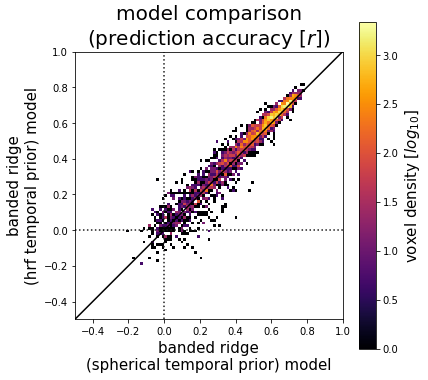

In [23]:
ax = plot_model_2dhist_comparison(np.nan_to_num(fit_banded_polar['performance'].squeeze()),
                                           np.nan_to_num(fit_bandedhrf_polar['performance'].squeeze()),
                                           'banded ridge\n(spherical temporal prior)', 
                                           'banded ridge\n(hrf temporal prior)')